**Utilisation de Google Colab avec Hyperas**

Accès au drive et chargement du fichier de données

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Le contenu de votre drive google est alors accessible depuis le panneau de navigation de gauche : 

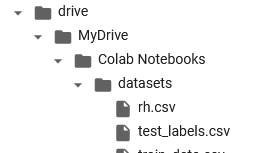

Cliquer droit sur le fichier de données et copier le chemin d'accès :


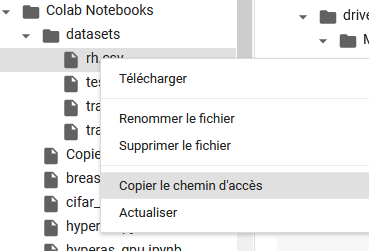

In [ ]:
url='/content/drive/MyDrive/Colab Notebooks/datasets/rh.csv'

In [ ]:
import pandas as pd

In [ ]:
pd.read_csv(url)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


Activer le mode d'éxécution par GPU. Menu Execution, Modifier le type d'éxecution puis choisir GPU : 

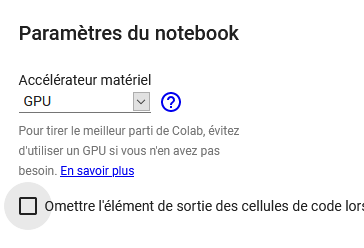 

Test de présence de GPU et obtention du nom du périphérique.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras import utils as np_utils
from keras.layers import Dense, Activation, Dropout

Installation de hyperas

In [ ]:
%pip install hyperas

In [ ]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Mise en place de la fonction de pretraitement des données

In [ ]:
def data_preproc():
  url='/content/drive/MyDrive/Colab Notebooks/datasets/rh.csv'
  df=pd.read_csv(url)
  features = ['sales','salary']
  df_final = pd.get_dummies(df,columns=features,drop_first=True)
  from sklearn.model_selection import train_test_split
  X = df_final.drop(['left'],axis=1).values
  y = df_final['left'].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, y_train, X_val, y_val, X_test,y_test

Définition du modèle en utilisant les dictionniares d'hyperparamètres pour hyperas:

In [ ]:
def modele(X_train, y_train, X_val, y_val):
    
    model = Sequential()
    model.add(Dense({{choice([100, 200, 300])}}, input_shape=(18,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dense({{choice([50,100])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, y_train,
            batch_size={{choice([128,256,512])}},
            epochs=20,
            verbose=2,
            validation_data=(X_val, y_val))
    score, acc = model.evaluate(X_val, y_val, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

Lancement de l'entrainnement et de la recherche des meilleurs hyperparamètres : 

In [ ]:
with tf.device('/device:GPU:0'):
  best_run, best_model = optim.minimize(model=modele,
                                      data=data_preproc,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='/drive/MyDrive/Colab Notebooks/rh')

>>> Imports:
#coding=utf-8

try:
    from google.colab import drive
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from tensorflow import keras
except:
    pass

try:
    from keras.datasets import fashion_mnist
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from keras import utils as np_utils
except:
    pass

try:
    from keras.layers import Dense, Activation, Dropout
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    import joblib
except:
    pass

>>> Hyper

Obtention du meilleur modèle : 

In [ ]:
best_run

{'Activation': 0,
 'Activation_1': 0,
 'Dense': 1,
 'Dense_1': 1,
 'batch_size': 1,
 'choiceval': 2,
 'lr': 0,
 'lr_1': 1,
 'lr_2': 2}

Les résultats obtenus correspondent donc au réseau suivant :

    model = Sequential()
    model.add(Dense(200, input_shape=(18,)))
    model.add(Activation('relu']))
    model.add(Dense(100)
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optimiseur = keras.optimizers.RMSprop(learning_rate=10**-1})   
    model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opimiseur)

Evaluation du modèle

In [ ]:
X_train, y_train, X_val, y_val, X_test,y_test= data_preproc()
best_model.evaluate(X_test, y_test)

141/141 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.9733


[0.11275255680084229, 0.9733333587646484]

Résumé

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               3800      
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 24,001
Trainable params: 24,001
Non-trainable params: 0
____________________________________________________

Sauvegarde du modèle retenu

In [ ]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/modele_rh_ann.h5')
#Chargement
from keras.models import load_model
model = load_model('model.h5')

**Sauvegrade de structure et de coefficients séparément**

In [ ]:
from keras.models import model_from_json
# Architecture du modele au format JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# Archivage des coefficient de l'entrainement au format HDF5
best_model.save_weights("/content/drive/MyDrive/Colab Notebooks/model.h5")
 
# Procédure de chargement
 
# lecture du fichier json et creation du modèle
fichier = open('model.json', 'r')
recup_model_json = fichier.read()
fichier.close()
mon_modele = model_from_json(recup_model_json)
# Chargement des coefficients dans le modele
mon_modele.load_weights("/content/drive/MyDrive/Colab Notebooks/model.h5")
 